In [ ]:
from IPython.display import clear_output

In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [ ]:
import random

import torch
from torch.utils.data import Subset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [ ]:
print(len(image_dataset))

9144


label=0


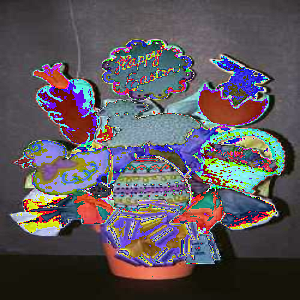

In [ ]:
img, label = image_dataset[50]
print(f'{label=}')
transforms.functional.to_pil_image(img)

In [ ]:


unique_labels = set()
for _, label in image_dataset:
    unique_labels.add(label)
print(f"Unique labels: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")


Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101}
Number of unique labels: 102


# Tasks:

1. Download pretrained Resnet18 model from torchhub
2. Modify the model for object 101 dataset subset (The dataset has 101 distinct classes).
3. Split the dataset between training and validation set (80% / 20%).
4. Fine tune the model for classification on the dataset.
5. Output the fine tuned model's overall accuracy on the validation set.
6. Find a way to show label wise performance/accuracy of the finetuned model.

In [ ]:
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.hub

In [ ]:
from torchvision import models

# Load pretrained rasnet18
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


In [ ]:
model.fc = nn.Linear(model.fc.in_features, 102) #this is used when using pretrained model it defines classifier (ResNet)

#model.fc = nn.Linear(model.fc.in_features, len(unique_labels)) #can be like this , we only change the output features only


#now we split the data:

dataset_size = len(image_dataset)
train_size = int(0.8 * dataset_size) #80% training
val_size = dataset_size - train_size #, validation is the rest

train_dataset, val_dataset = random_split(image_dataset, [train_size, val_size]) # split to these [train_size, val_size] arranged probably

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #DataLoader is handler of data
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss() # ResNet, Multi-Class Classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3 #best to reduce the time

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) #must be in GPU with the model

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0 #correct is how much the model got it right
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) #must be in GPU with the model too

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) #max or argmax check the differences (max returns the max value and the index)(argmax return the index of max value)
            #predicted = torch.argmax(outputs.data, 1) #take a single
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Validation Accuracy: {accuracy}')

Epoch 1, Loss: 1.5102490642796391, Validation Accuracy: 0.7003827227993439
Epoch 2, Loss: 0.49097063981968425, Validation Accuracy: 0.7353745215965009
Epoch 3, Loss: 0.2526355675381163, Validation Accuracy: 0.8288682340076544


In [ ]:
print(f' overall accuracy: {accuracy}')

 overall accuracy: 0.8288682340076544


In [ ]:
#same as the accuracy before but for every class not the model in total

class_correct = [0] * 102 # 102 number of labels(the classes)
class_total = [0] * 102

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


In [ ]:
for i in range(102):
    print(f'class {i}: {100 * class_correct[i] / class_total[i]}%')

class 0: 75.5813953488372%
class 1: 97.82608695652173%
class 2: 100.0%
class 3: 97.82608695652173%
class 4: 99.27007299270073%
class 5: 100.0%
class 6: 100.0%
class 7: 16.666666666666668%
class 8: 57.142857142857146%
class 9: 88.88888888888889%
class 10: 30.0%
class 11: 0.0%
class 12: 100.0%
class 13: 100.0%
class 14: 86.66666666666667%
class 15: 60.0%
class 16: 45.45454545454545%
class 17: 78.57142857142857%
class 18: 85.71428571428571%
class 19: 50.0%
class 20: 100.0%
class 21: 63.63636363636363%
class 22: 100.0%
class 23: 71.42857142857143%
class 24: 100.0%
class 25: 13.333333333333334%
class 26: 84.61538461538461%
class 27: 47.05882352941177%
class 28: 42.857142857142854%
class 29: 16.666666666666668%
class 30: 93.33333333333333%
class 31: 83.33333333333333%
class 32: 47.05882352941177%
class 33: 75.0%
class 34: 53.333333333333336%
class 35: 92.3076923076923%
class 36: 85.71428571428571%
class 37: 72.22222222222223%
class 38: 58.8235294117647%
class 39: 86.66666666666667%
class 40: